In [26]:
from pickle import dump

import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, ttest_rel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import config

data = pd.read_csv(config.output_csv)

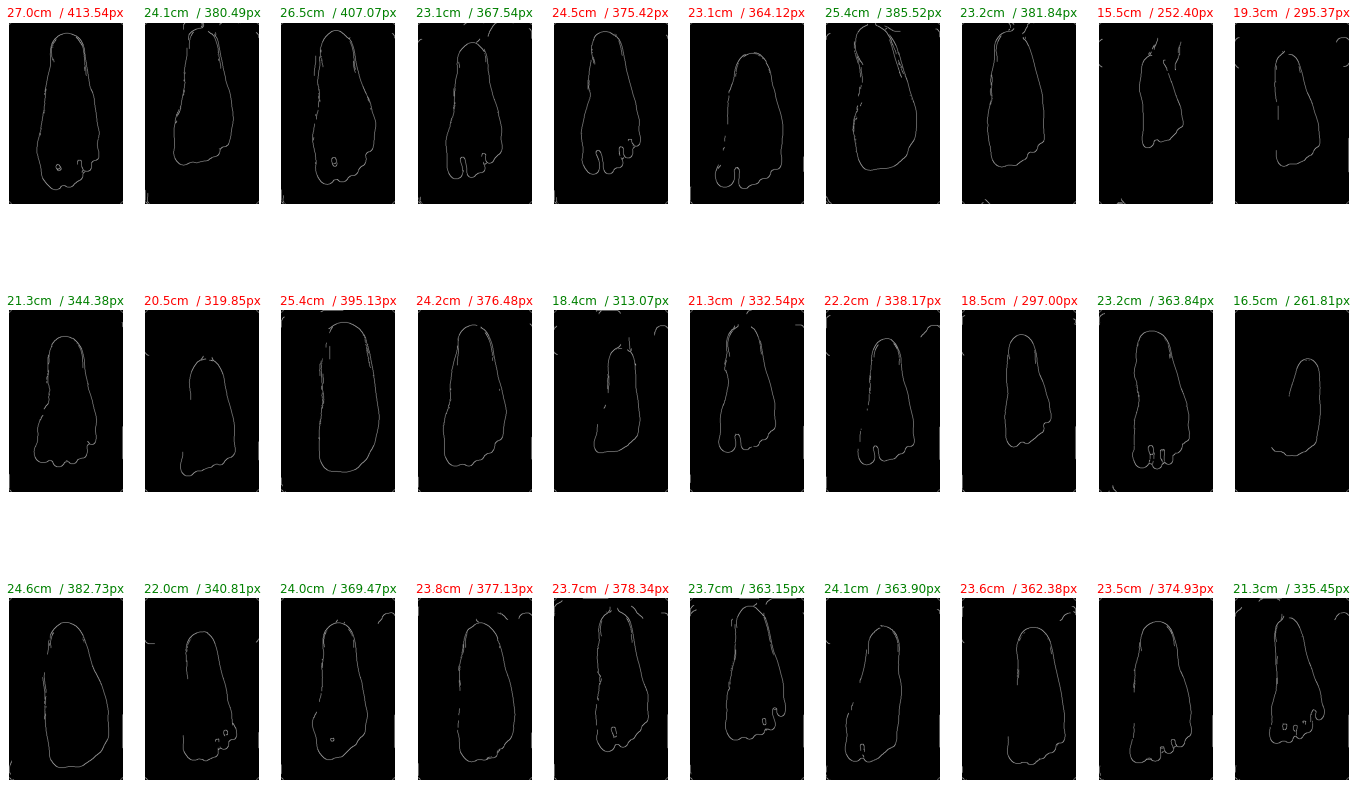

In [88]:
import os
import re

import cv2
import pandas as pd

import config
from canny_edge_detection import median_filter, detect_edges, slice_image
from foot_measurement import get_foot_dimensions_px
import matplotlib.pyplot as plt

_, axs = plt.subplots(3, 10, figsize=(24, 15))

samples_folder = 'Samples'
pattern = re.compile(r"(?P<id>\w+) (?P<cm>\d+\.\d+)")

iaxs = iter(axs.flatten())
test_idx = [0, 4, 5, 8, 9, 11, 12, 13, 15, 16, 17, 23, 24, 27, 28]
for i, (sample_file, ax) in enumerate(zip(os.listdir(samples_folder), iaxs)):
    match = pattern.search(sample_file)
    if not match:
        continue

    img = cv2.imread(f'{samples_folder}/{sample_file}', 0)
    img = slice_image(img, **config.image_bounds)
    edge = detect_edges(img, median_filter)
    px = get_foot_dimensions_px(edge)
    
    ax.imshow(edge, cmap=plt.cm.gray)
    ax.axis('off')
#     ax.set_title(f"{match.group('id')}: {match.group('cm')}cm", fontstyle='italic')
    ax.set_title(f"{match.group('cm')}cm  / {px[0]:.2f}px", color=f"{'red' if i in test_idx else 'green'}")

for ax in (iaxs):
    ax.axis('off')

plt.show()

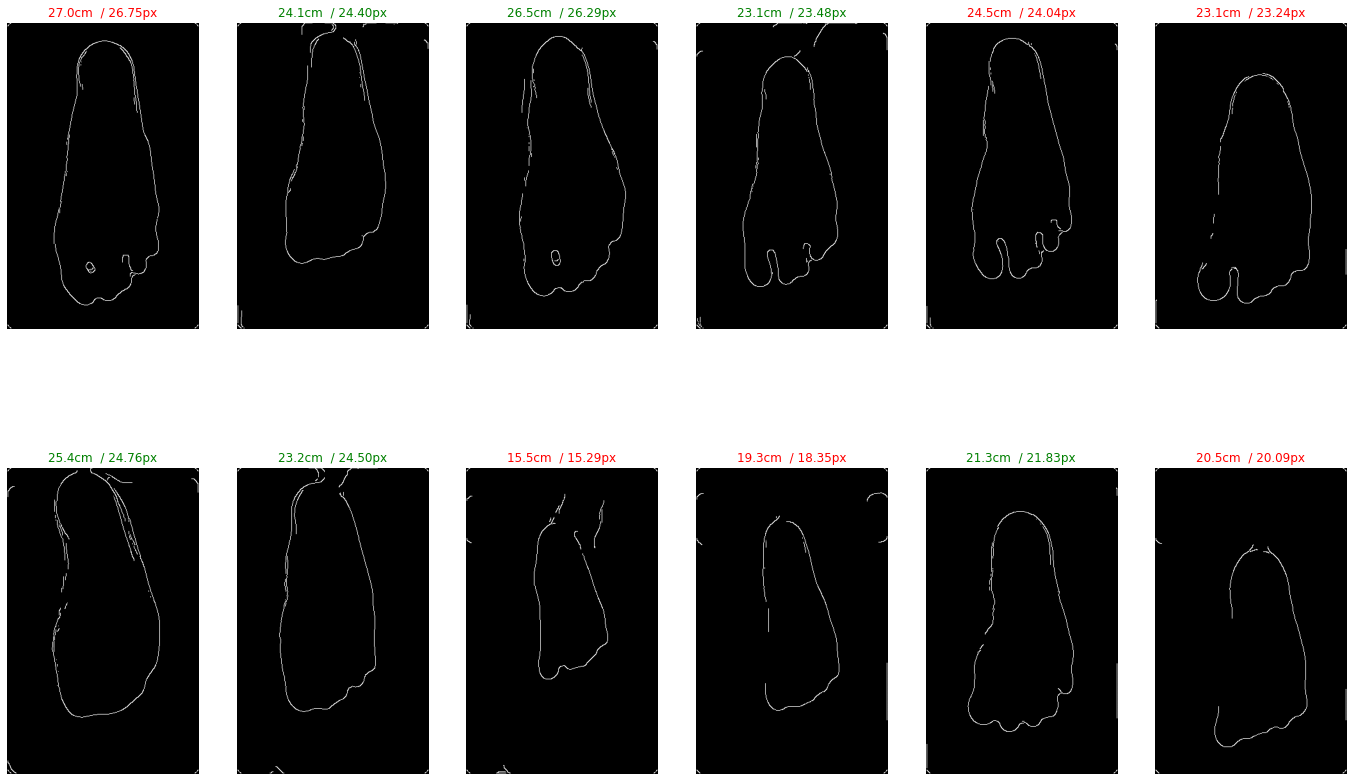

In [91]:
import os
import re

import cv2
import pandas as pd

import config
from canny_edge_detection import median_filter, detect_edges, slice_image
from foot_measurement import get_foot_dimensions_px, convert_px_to_cm
import matplotlib.pyplot as plt

_, axs = plt.subplots(2, 6, figsize=(24, 15))

samples_folder = 'Samples'
pattern = re.compile(r"(?P<id>\w+) (?P<cm>\d+\.\d+)")

iaxs = iter(axs.flatten())
test_idx = [0, 4, 5, 8, 9, 11, 12, 13, 15, 16, 17, 23, 24, 27, 28]
for i, (sample_file, ax) in enumerate(zip(os.listdir(samples_folder), iaxs)):
    match = pattern.search(sample_file)
    if not match:
        continue

    img = cv2.imread(f'{samples_folder}/{sample_file}', 0)
    img = slice_image(img, **config.image_bounds)
    edge = detect_edges(img, median_filter)
    px = get_foot_dimensions_px(edge)
    cm = convert_px_to_cm(px)
    
    ax.imshow(edge, cmap=plt.cm.gray)
    ax.axis('off')
#     ax.set_title(f"{match.group('id')}: {match.group('cm')}cm", fontstyle='italic')
    ax.set_title(f"{match.group('cm')}cm  / {cm:.2f}px", color=f"{'red' if i in test_idx else 'green'}")

for ax in (iaxs):
    ax.axis('off')

plt.show()

In [27]:
# model 1

X = data[['h_px']].values.reshape(-1, 1)
Y = data['cm'].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42)

reg = LinearRegression().fit(x_train, y_train)

print(f'     r2: {reg.score(x_test, y_test)}')
print(f'      m: {reg.coef_[0]}')
print(f'      b: {reg.intercept_}')

calculated, measured = reg.predict(x_test), y_test
alpha, delta = 0.05, 0.5
t, p = res = ttest_rel(calculated, measured)

# Compare the p-value to the level of significance
if p < alpha:
    # Reject the null hypothesis
    print("The means are not equal within the margin of equivalence.")
else:
    # Fail to reject the null hypothesis
    mean_diff = np.mean(np.abs(calculated - measured))
    print(mean_diff)
    if mean_diff <= delta:
        print("The means are equal within the margin of equivalence.")
    else:
        print("The means are not equal within the margin of equivalence.")

res

     r2: 0.3882610436464663
      m: [0.02739993]
      b: [13.15470945]
1.628900963037091
The means are not equal within the margin of equivalence.


Ttest_relResult(statistic=array([0.65846784]), pvalue=array([0.52091994]))

In [28]:
np.concatenate([y_train, reg.predict(x_train), x_train], axis=1)

array([[ 24.        ,  24.8407872 , 426.50030518],
       [ 24.1       ,  23.53232105, 378.74594116],
       [ 26.5       ,  24.33787877, 408.14593506],
       [ 23.7       ,  23.47088611, 376.50378418],
       [ 23.1       ,  23.23788304, 368.        ],
       [ 22.        ,  19.87802454, 245.37710571],
       [ 24.1       ,  23.69018003, 384.50723267],
       [ 23.2       ,  23.18218011, 365.96704102],
       [ 21.3       ,  23.80319888, 388.63201904],
       [ 24.6       ,  23.70074683, 384.8928833 ],
       [ 23.2       ,  23.63538351, 382.50735474],
       [ 21.3       ,  22.64559455, 346.38357544],
       [ 18.4       ,  21.16483949, 292.34127808],
       [ 16.5       ,  16.4074473 , 118.71337128],
       [ 25.4       ,  23.8726486 , 391.16668701]])

In [71]:
y, y_hat = y_test, reg.predict(x_test)
d = y - y_hat
d_bar = np.mean(d)
np.concatenate([y, x_test], axis=1)

array([[ 23.6       , 415.4017334 ],
       [ 21.3       , 353.56118774],
       [ 23.8       , 436.33651733],
       [ 18.5       , 332.20697021],
       [ 15.5       , 309.98568726],
       [ 19.3       , 253.30018616],
       [ 23.5       , 377.90777588],
       [ 23.7       , 405.15661621],
       [ 25.4       , 397.14407349],
       [ 27.        , 414.        ],
       [ 24.5       , 377.24682617],
       [ 22.2       , 263.39569092],
       [ 23.1       , 365.15100098],
       [ 24.2       , 378.86138916],
       [ 20.5       , 196.84605408]])

In [72]:
a = [0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 23, 24, 25, 27, 28, 29]
x = [i for i in range(30) if (Y[i] in y and X[i] in x_test)]

In [75]:
x

[0, 4, 5, 8, 9, 11, 12, 13, 15, 16, 17, 23, 24, 27, 28]

In [70]:
np.concatenate([np.array(list(range(30))).reshape(-1, 1), Y, X], axis=1)

array([[  0.        ,  27.        , 414.        ],
       [  1.        ,  24.1       , 378.74594116],
       [  2.        ,  26.5       , 408.14593506],
       [  3.        ,  23.1       , 368.        ],
       [  4.        ,  24.5       , 377.24682617],
       [  5.        ,  23.1       , 365.15100098],
       [  6.        ,  25.4       , 391.16668701],
       [  7.        ,  23.2       , 382.50735474],
       [  8.        ,  15.5       , 309.98568726],
       [  9.        ,  19.3       , 253.30018616],
       [ 10.        ,  21.3       , 346.38357544],
       [ 11.        ,  20.5       , 196.84605408],
       [ 12.        ,  25.4       , 397.14407349],
       [ 13.        ,  24.2       , 378.86138916],
       [ 14.        ,  18.4       , 292.34127808],
       [ 15.        ,  21.3       , 353.56118774],
       [ 16.        ,  22.2       , 263.39569092],
       [ 17.        ,  18.5       , 332.20697021],
       [ 18.        ,  23.2       , 365.96704102],
       [ 19.        ,  16.5    

In [34]:
import math

In [36]:
round(2.56456, 2)

2.56

In [7]:
if p > 0.05:
    mean_diff = np.mean(np.abs(calculated - measured))
    print('Average error', mean_diff)
    if mean_diff < delta:
        print("The means are equivalent within the specified equivalence margin of", delta)
    else:
        print("The means are not equivalent")
else:
    print("Reject the null hypothesis")

Average error 1.628900963037091
The means are not equivalent


In [108]:
np.mean(y - y_hat)

0.15985475214910164

In [115]:
np.std(y - y_hat)

0.4247849793726239

In [91]:
np.concatenate([Y, reg.predict(X)], axis=1)

array([[27.        , 26.675041  ],
       [24.1       , 24.41133575],
       [26.5       , 26.23147273],
       [23.1       , 23.52453778],
       [24.5       , 24.06441917],
       [23.1       , 23.29073123],
       [25.4       , 24.75587397],
       [23.2       , 24.50399773],
       [15.5       , 15.63973186],
       [19.3       , 18.58201783],
       [21.3       , 21.93851668],
       [20.5       , 20.25843959],
       [25.4       , 25.4142052 ],
       [24.2       , 24.13710962],
       [18.4       , 19.79411606],
       [21.3       , 21.12780114],
       [22.2       , 21.51295748],
       [18.5       , 18.69381119],
       [23.2       , 23.27137832],
       [16.5       , 16.28408134],
       [24.6       , 24.56481728],
       [22.        , 21.69387374],
       [24.        , 23.65661407],
       [23.8       , 24.18154816],
       [23.7       , 24.26395687],
       [23.7       , 23.22395951],
       [24.1       , 23.27538265],
       [23.6       , 23.17106086],
       [23.5       ,

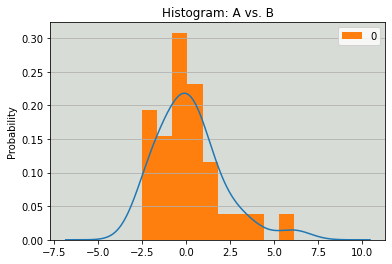

In [26]:
import matplotlib.pyplot as plt

d = pd.DataFrame(reg.predict(X) - Y)

fig, ax = plt.subplots()
d.plot.kde(ax=ax, legend=False, title='Histogram: A vs. B')
d.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

In [54]:
sum(d)

0

In [3]:
# model 2

X = data[['h_px', 'w_px']].values.reshape(-1, 2)
Y = data['cm'].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42)

reg = LinearRegression().fit(x_train, y_train)

print(f'     r2: {reg.score(x_test, y_test)}')
print(f'      m: {reg.coef_[0]}')
print(f'      b: {reg.intercept_}')

ttest_1samp(np.abs(reg.predict(X) - Y), 1)

     r2: 0.9626958076021519
      m: [0.06247558 0.01922698]
      b: [-2.36993031]


Ttest_1sampResult(statistic=array([-8.3141958]), pvalue=array([3.6414767e-09]))

In [4]:
# model 3

X = data[['h_px', 'w_px']].values.reshape(-1, 2) ** 2
Y = data['cm'].values.reshape(-1, 1) ** 2

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42)

reg = LinearRegression().fit(x_train, y_train)

print(f'     r2: {reg.score(x_test, y_test)}')
print(f'      m: {reg.coef_[0]}')
print(f'      b: {reg.intercept_}')

ttest_1samp(np.abs(np.sqrt(reg.predict(X)) - np.sqrt(Y)), 1)

     r2: 0.9677194649848938
      m: [0.00410402 0.00239091]
      b: [-56.21928622]


Ttest_1sampResult(statistic=array([-8.95296173]), pvalue=array([7.62472452e-10]))